In [1]:
!pip install SimpleITK intensity_normalization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 75.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=dcdbaa339d31c0352ea9aaee1f542ecab8d609645edf4140f7a442c3c210db48
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy
  Attempting uninstall: nibabel
    Found existing installation: nibabel 4.0.2
    Uninstalling nibabel-4.0.2:
      Successfully uninstalled nibabel-4.0.2


**Import libraries**

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

**Mount drive**

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


**Define parameters**

In [4]:
# dataset parameters
FNAME_PATTERN = '/content/drive/MyDrive/IBSR/{0}/IBSR_{1:02d}/IBSR_{1:02d}{2}.nii.gz'
IMAGE_SIZE = (128, 256, 256)


# network parameters
N_CLASSES = 4
N_INPUT_CHANNELS = 1
SCALING_FACTOR = 1
PATCH_SIZE = (64, 64)
PATCH_STRIDE = (32, 32)

# training, validation, test parameters
TRAINING_VOLUMES = [1, 3, 4, 5, 6, 7, 8, 9, 16, 18]
VALIDATION_VOLUMES = [11, 12, 13, 14, 17]
TEST_VOLUMES = [2, 10, 15]

# data preparation parameters
CONTENT_THRESHOLD = 0.1

# training parameters
N_EPOCHS = 50
BATCH_SIZE = 64
PATIENCE = 20
MODEL_FOLDER = 'checkpoint'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'

**Define SegNet architecture**

In [5]:
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scaling_factor=SCALING_FACTOR):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scaling_factor, (3, 3), padding="same", activation='relu')(inputs)
    max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64*scaling_factor, (3, 3), padding="same", activation='relu')(max1)
    max2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128*scaling_factor, (3, 3), padding="same", activation='relu')(max2)
    max3 = layers.MaxPooling2D((2, 2))(conv3)

    lat = layers.Conv2D(256*scaling_factor, (3, 3), padding="same", activation='relu')(max3)

    up1 = layers.UpSampling2D((2, 2))(lat)
    cat1 = layers.Concatenate()([up1, conv3])
    conv4 = layers.Conv2D(128*scaling_factor, (3, 3), padding="same", activation='relu')(cat1)

    up2 = layers.UpSampling2D((2, 2))(conv4)
    cat2 = layers.Concatenate()([up2, conv2])
    conv5 = layers.Conv2D(64*scaling_factor, (3, 3), padding="same", activation='relu')(cat2)

    up3 = layers.UpSampling2D((2, 2))(conv5)
    cat3 = layers.Concatenate()([up3, conv1])
    conv6 = layers.Conv2D(32*scaling_factor, (3, 3), padding="same", activation='relu')(cat3)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)

    model = keras.Model(inputs, outputs)

    return model

**Load data**

In [8]:
def load_data(volume_list, folder_name, image_size=IMAGE_SIZE, fname_pattern=FNAME_PATTERN):
    n_volumes = len(volume_list)
    T1_volumes = np.zeros((n_volumes, *image_size, 1))
    labels = np.zeros((n_volumes, *image_size, 1))

    for iFile, iID in enumerate(volume_list):
        # Format the file name pattern with the folder name and the volume ID
        preprocessed_fname = fname_pattern.format(folder_name, iID, '_preprocessed_histmatched')
        img_data = nib.load(preprocessed_fname).get_fdata()
        print(f"Shape of T1 volume {iID} before transpose: {img_data.shape}")

        # Correct transpose operation for T1 volumes
        if img_data.shape != image_size:
            img_data = np.transpose(img_data, (1, 2, 0))
        print(f"Shape of T1 volume {iID} after transpose: {img_data.shape}")

        # Check and assign for T1 volumes
        if img_data.shape == image_size:
            T1_volumes[iFile, ..., 0] = img_data
        else:
            print(f"Error: Shape of T1 volume {iID} does not match expected shape {image_size}")

        # Load segmentation label and remove the singleton dimension
        # Load segmentation data
        seg_fname = fname_pattern.format(folder_name, iID, '_seg')
        seg_data = nib.load(seg_fname).get_fdata()[..., 0]
        print(f"Shape of segmentation label {iID} before transpose: {seg_data.shape}")

        # Correct transpose for segmentation labels
        if seg_data.shape != image_size:
            seg_data = np.transpose(seg_data, (1, 2, 0))
        print(f"Shape of segmentation label {iID} after transpose: {seg_data.shape}")

        # Check and assign for segmentation labels
        if seg_data.shape == image_size:
            labels[iFile, ..., 0] = seg_data
        else:
            print(f"Error: Shape of segmentation label {iID} does not match expected shape {image_size}")

    return (T1_volumes, labels)

In [9]:
(training_volumes_T1, training_labels) = load_data(TRAINING_VOLUMES, "Training_Set")
(validation_volumes_T1, validation_labels) = load_data(VALIDATION_VOLUMES, "Validation_Set")

Shape of T1 volume 1 before transpose: (256, 128, 256)
Shape of T1 volume 1 after transpose: (128, 256, 256)
Shape of segmentation label 1 before transpose: (256, 128, 256)
Shape of segmentation label 1 after transpose: (128, 256, 256)
Shape of T1 volume 3 before transpose: (256, 128, 256)
Shape of T1 volume 3 after transpose: (128, 256, 256)
Shape of segmentation label 3 before transpose: (256, 128, 256)
Shape of segmentation label 3 after transpose: (128, 256, 256)
Shape of T1 volume 4 before transpose: (256, 128, 256)
Shape of T1 volume 4 after transpose: (128, 256, 256)
Shape of segmentation label 4 before transpose: (256, 128, 256)
Shape of segmentation label 4 after transpose: (128, 256, 256)
Shape of T1 volume 5 before transpose: (256, 128, 256)
Shape of T1 volume 5 after transpose: (128, 256, 256)
Shape of segmentation label 5 before transpose: (256, 128, 256)
Shape of segmentation label 5 after transpose: (128, 256, 256)
Shape of T1 volume 6 before transpose: (256, 128, 256)
S

**Pre-process data**

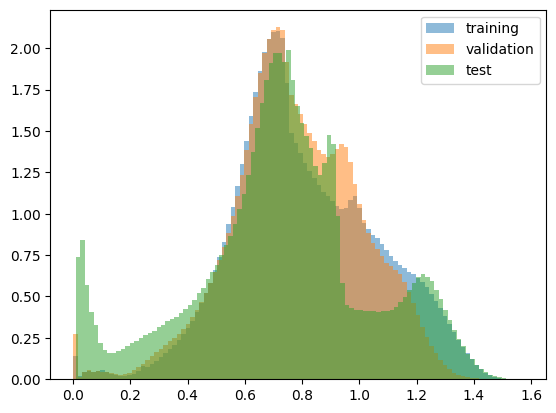

In [15]:
plt.hist(training_volumes_T1[training_labels>0].flatten(), 100, label='training', alpha=0.5, density=True)
plt.hist(validation_volumes_T1[validation_labels>0].flatten(), 100, label='validation', alpha=0.5, density=True)
# plt.hist(testing_volumes_T1[testing_volumes_T1>0.01].flatten(), 100, label='test', alpha=0.5, density=True)
plt.legend(loc='upper right')
plt.show()

**Extract *useful* patches**

This step is fundamental, we want to provide the network with useful information

In [9]:
def extract_patches(x, patch_size, patch_stride) :
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [10]:
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :
  volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
  labels = labels.reshape([-1, image_size[1], image_size[2], 1])

  vol_patches = extract_patches(volumes, patch_size, stride).numpy()
  seg_patches = extract_patches(labels, patch_size, stride).numpy()

  vol_patches = vol_patches.reshape([-1, *patch_size, 1])
  seg_patches = seg_patches.reshape([-1, *patch_size, ])

  foreground_mask = seg_patches != 0

  useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

  vol_patches = vol_patches[useful_patches]
  seg_patches = seg_patches[useful_patches]

  seg_patches = tf.keras.utils.to_categorical(
    seg_patches, num_classes=N_CLASSES, dtype='float32')

  return (vol_patches, seg_patches)

In [11]:
# extract patches from training set
(training_patches_T1, training_patches_seg) = extract_useful_patches(training_volumes_T1, training_labels)

# extract patches from validation set
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(validation_volumes_T1, validation_labels)

In [12]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FOLDER + "/best_model_all_2.h5", save_best_only=True)
]

segnet = get_unet()
segnet.compile(optimizer=OPTIMISER, loss=LOSS)

h = segnet.fit(
    x=training_patches_T1,
    y=training_patches_seg,
    validation_data=(validation_patches_T1, validation_patches_seg),  # Include validation data
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/20
139/139 [==============================] - 20s 77ms/step - loss: 0.4879 - val_loss: 0.3467
Epoch 2/20
  1/139 [..............................] - ETA: 5s - loss: 0.3126

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 7s 53ms/step - loss: 0.2757 - val_loss: 0.2381
Epoch 3/20
139/139 [==============================] - 7s 52ms/step - loss: 0.2128 - val_loss: 0.2296
Epoch 4/20
139/139 [==============================] - 7s 51ms/step - loss: 0.1749 - val_loss: 0.1902
Epoch 5/20
139/139 [==============================] - 8s 54ms/step - loss: 0.1503 - val_loss: 0.1560
Epoch 6/20
139/139 [==============================] - 7s 54ms/step - loss: 0.1387 - val_loss: 0.1475
Epoch 7/20
139/139 [==============================] - 7s 53ms/step - loss: 0.1280 - val_loss: 0.1485
Epoch 8/20
139/139 [==============================] - 7s 53ms/step - loss: 0.1196 - val_loss: 0.1455
Epoch 9/20
139/139 [==============================] - 7s 54ms/step - loss: 0.1119 - val_loss: 0.1474
Epoch 10/20
139/139 [==============================] - 7s 52ms/step - loss: 0.1061 - val_loss: 0.1489
Epoch 11/20
139/139 [==============================] - 7s 54ms/step - loss: 0.1021 - val_loss: 0.1433

In [13]:
from google.colab import files
files.download(MODEL_FOLDER + "/best_model_all_2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

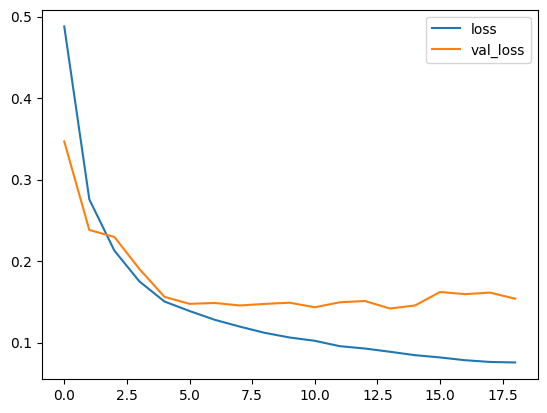

In [14]:
# Number of epochs actually trained
actual_epochs = len(h.history['loss'])

plt.figure()
plt.plot(range(actual_epochs), h.history['loss'], label='loss')
plt.plot(range(actual_epochs), h.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

**Load best model**: the one int the checkpoint folder

In [14]:
# unet = get_unet(
#     img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
#     n_classes=N_CLASSES,
#     n_input_channels=N_INPUT_CHANNELS)

# unet.compile(optimizer=OPTIMISER, loss=LOSS)
# unet.load_weights(MODEL_FOLDER  + "/best_model_all_2.h5")

**Prepare test data**

In [6]:
def load_test_data(volume_list, folder_name, image_size=IMAGE_SIZE, fname_pattern=FNAME_PATTERN):
    n_volumes = len(volume_list)
    T1_volumes = np.zeros((n_volumes, *image_size, 1))

    for iFile, iID in enumerate(volume_list):
        # Load T1 volume (preprocessed image)
        preprocessed_fname = fname_pattern.format(folder_name, iID, '_preprocessed_histmatched')
        img_data = nib.load(preprocessed_fname).get_fdata()
        print(f"Shape of T1 volume {iID} before transpose: {img_data.shape}")

        # Correct transpose operation for T1 volumes
        if img_data.shape != image_size:
            img_data = np.transpose(img_data, (1, 2, 0))
        print(f"Shape of T1 volume {iID} after transpose: {img_data.shape}")

        # Check and assign for T1 volumes
        if img_data.shape == image_size:
            T1_volumes[iFile, ..., 0] = img_data
        else:
            print(f"Error: Shape of T1 volume {iID} does not match expected shape {image_size}")

    return T1_volumes

In [10]:
# (testing_volumes_T1) = load_test_data(TEST_VOLUMES, 'Test_Set')
testing_volumes_T1_processed = validation_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1]) # It was test_volumes_T1
testing_labels_processed = validation_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2]]) # Its was test_labels

**Predict labels for test data**

In [15]:
prediction = unet.predict(x=testing_volumes_T1_processed)

prediction = np.argmax(prediction, axis=3)

20/20 [==============================] - 8s 91ms/step


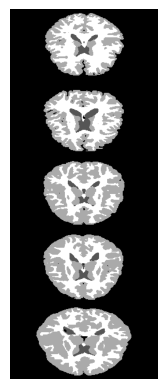

In [16]:
slice_to_display = prediction[:, 144, :]
plt.axis('off')

# Plot the slice
plt.imshow(slice_to_display, cmap='gray')

In [18]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214949 sha256=0077a78aec1c24fbb1d19cf0ee2fb8a8697663a0a89378b122c82ccb5ccbcafe
  Stored in directory: /root/.cache/pip/wheels/d4/32/c7/6380ab2edb8cca018d39a0f1d43250fd9791922c963117de46
Successfully built medpy


In [22]:
import pandas as pd
from medpy.metric.binary import dc, hd, ravd

results = []
slices_per_image = 128  # Assuming 128 slices per image

for i in range(5):  # For each of the 5 images
    start_slice = i * slices_per_image
    end_slice = (i + 1) * slices_per_image

    image_prediction = prediction[start_slice:end_slice]
    image_label = testing_labels_processed[start_slice:end_slice]
    image_metrics = {'Image_Name': str(VALIDATION_VOLUMES[i])}  # Store image name

    for c in [1, 2, 3]:  # Iterate over the specified classes
        if c in np.unique(image_label):
            dsc_val = dc(image_prediction == c, image_label == c)
            hd_val = hd(image_prediction == c, image_label == c, voxelspacing=[1, 1, 1], connectivity=1)
            # Store the calculated metrics for each class
            image_metrics[f'Dice_class_{c}'] = dsc_val
            image_metrics[f'HD_class_{c}'] = hd_val

    results.append(image_metrics)

# Convert the results to a DataFrame and save as CSV
results_df = pd.DataFrame(results)
results_df.to_csv('segmentation_metrics.csv', index=False)


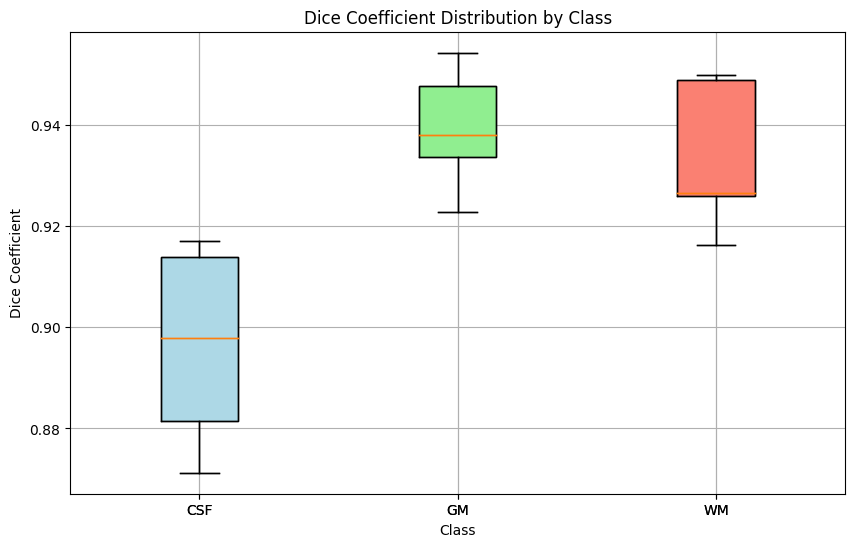

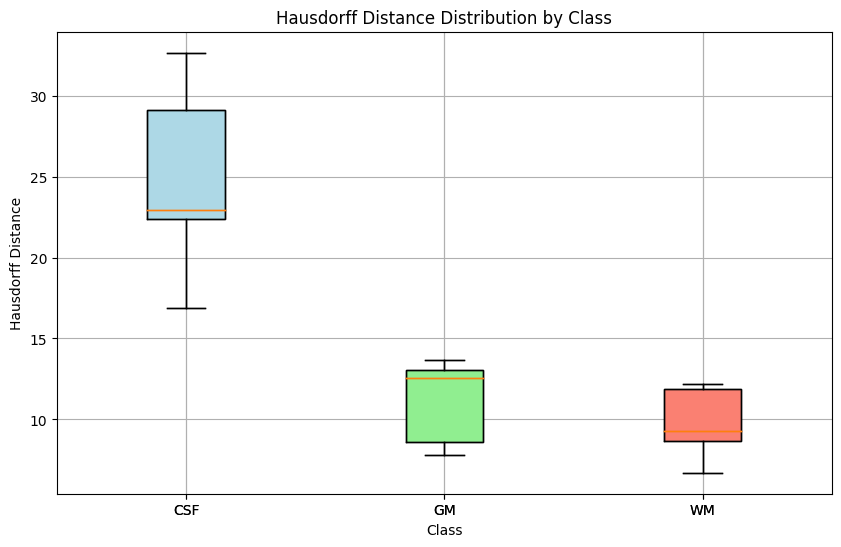

In [30]:
import matplotlib.pyplot as plt

# Extracting Dice and HD values for each class
dice_class_1 = results_df['Dice_class_1'].dropna()
dice_class_2 = results_df['Dice_class_2'].dropna()
dice_class_3 = results_df['Dice_class_3'].dropna()

hd_class_1 = results_df['HD_class_1'].dropna()
hd_class_2 = results_df['HD_class_2'].dropna()
hd_class_3 = results_df['HD_class_3'].dropna()

# Define colors for each tissue type
colors = ['lightblue', 'lightgreen', 'salmon']

# Create box plots
plt.figure(figsize=(10, 6))
box = plt.boxplot([dice_class_1, dice_class_2, dice_class_3], labels=['CSF', 'GM', 'WM'], patch_artist=True)

# Apply colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Create box plot for Dice values
# plt.figure(figsize=(10, 6))
plt.boxplot([dice_class_1, dice_class_2, dice_class_3], labels=['CSF', 'GM', 'WM'])
plt.title('Dice Coefficient Distribution by Class')
plt.ylabel('Dice Coefficient')
plt.xlabel('Class')
plt.grid(True)
plt.show()

# Create box plot for HD values
plt.figure(figsize=(10, 6))
box = plt.boxplot([hd_class_1, hd_class_2, hd_class_3], labels=['CSF', 'GM', 'WM'], patch_artist=True)

# Apply colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.boxplot([hd_class_1, hd_class_2, hd_class_3], labels=['CSF', 'GM', 'WM'])
plt.title('Hausdorff Distance Distribution by Class')
plt.ylabel('Hausdorff Distance')
plt.xlabel('Class')
plt.grid(True)
plt.show()